<a href="https://colab.research.google.com/github/Osmayda/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Product Sales**

Author: Osmayda Nino

# **Import Libraries**

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

## saving variables for next lesson/notebook
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

import warnings
warnings.filterwarnings('ignore')

# **Load and Inspect Data**

In [2]:
#load the dataset
df = pd.read_csv("Data/sales_predictions_2023.csv")
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700


## **Clean Data**

## Rows and Columns

In [3]:
df.shape

(8523, 12)

## Datatypes

In [4]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## Duplicates

Are there duplicates? If so, drop any duplicates

In [5]:
df.duplicated().sum()

0

## Identify missing values.

In [6]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Item_Weight and Outlet_Size have some missing(null) values.

## **Clean Missing Item_Weight**

Because Item_Weight is a nubmerical value, we should be able to use mean, median, or mode to impute values. 

We will use mean.

In [7]:
median_item_weight = df['Item_Weight'].median()
df['Item_Weight'].fillna(median_item_weight, inplace=True)

Confirm that there are no missing values after addressing them (Item_Weight)

In [8]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## Clean Missing Outlet_Size

In [9]:
pd.unique(df['Outlet_Size'])

array(['Medium', nan, 'High', 'Small'], dtype=object)

Outlet-Size has 4 categories: Small, Medium, High, and nan. Mean, medium, or mode would not create a clearer picture for the size of the outlet therefore we will create a category called "missing".

In [10]:
df['Outlet_Size'].fillna("missing", inplace=True)

In [11]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Find and fix any inconsistent categories of data (example: fix cat, Cat, and cats so that they are consistent).

Check the unique values and counts of the 'Item_Weight'

In [12]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

Standardize the values in the Item_Fat_Content column

In [13]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'].value_counts()

Low Fat    5405
Regular    2889
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [14]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    2889
reg         117
Name: Item_Fat_Content, dtype: int64

In [15]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

For any numerical columns, obtain the summary statistics of each (min, max, mean).

Show summary stats for all numeric columns

In [16]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.00000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.81342,0.066132,140.992782,1997.831867,2181.288914
std,4.22724,0.051598,62.275067,8.371760,1706.499616
min,4.55500,0.000000,31.290000,1985.000000,33.290000
25%,9.31000,0.026989,93.826500,1987.000000,834.247400
50%,12.60000,0.053931,143.012800,1999.000000,1794.331000
75%,16.00000,0.094585,185.643700,2004.000000,3101.296400
max,21.35000,0.328391,266.888400,2009.000000,13086.964800


## **Exploratory Data Analysis**

In [17]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,missing,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Histogram

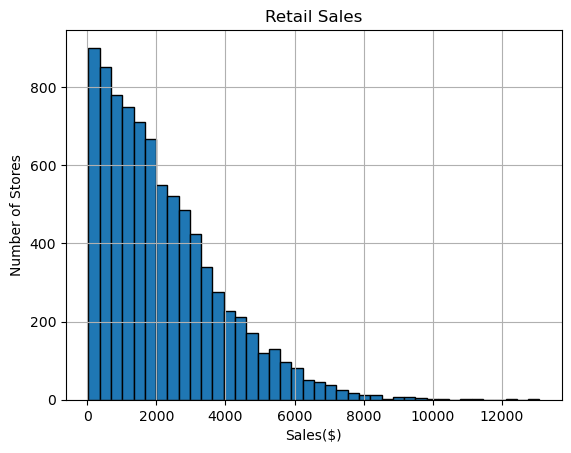

In [18]:
#define a MatplotLib ax object using pandas' .hist(bin=30)
ax = df['Item_Outlet_Sales'].hist(bins=40, edgecolor='black')

# Set the Title
ax.set_title('Retail Sales')
# Set the X axis label
ax.set_xlabel('Sales($)')
# Set the Y axis label
ax.set_ylabel('Number of Stores');

The number of sales increase as the size of the store increases. The bigger the store the more it sells.

- Use a Boxplot to compare the outlet type to its sales. 

In [19]:
# Display the descriptive statistics for the column
df['Item_Type'].describe()

count                      8523
unique                       16
top       Fruits and Vegetables
freq                       1232
Name: Item_Type, dtype: object

In [20]:
df['Outlet_Size'].describe()

count       8523
unique         4
top       Medium
freq        2793
Name: Outlet_Size, dtype: object

## Seaborn Box Plot

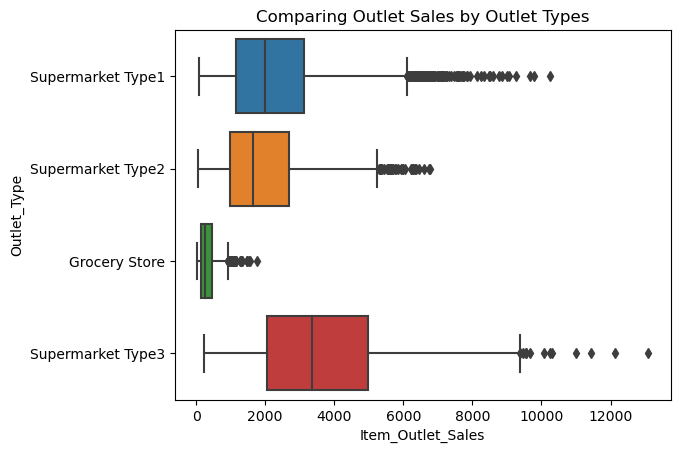

In [21]:
# Define a MatplotLib ax object using seaborn.boxplot()
ax = sns.boxplot(x='Item_Outlet_Sales', y='Outlet_Type', data=df)

#Set the Title
ax.set_title('Comparing Outlet Sales by Outlet Types');

Each Outlet Type has many outliers. 
- Supermarket Type1 has the most outliers. 
- Supermarket Type 1 has the higher max. 
- Supermarket Type 1 has a bigger IQR.


## Heatmap

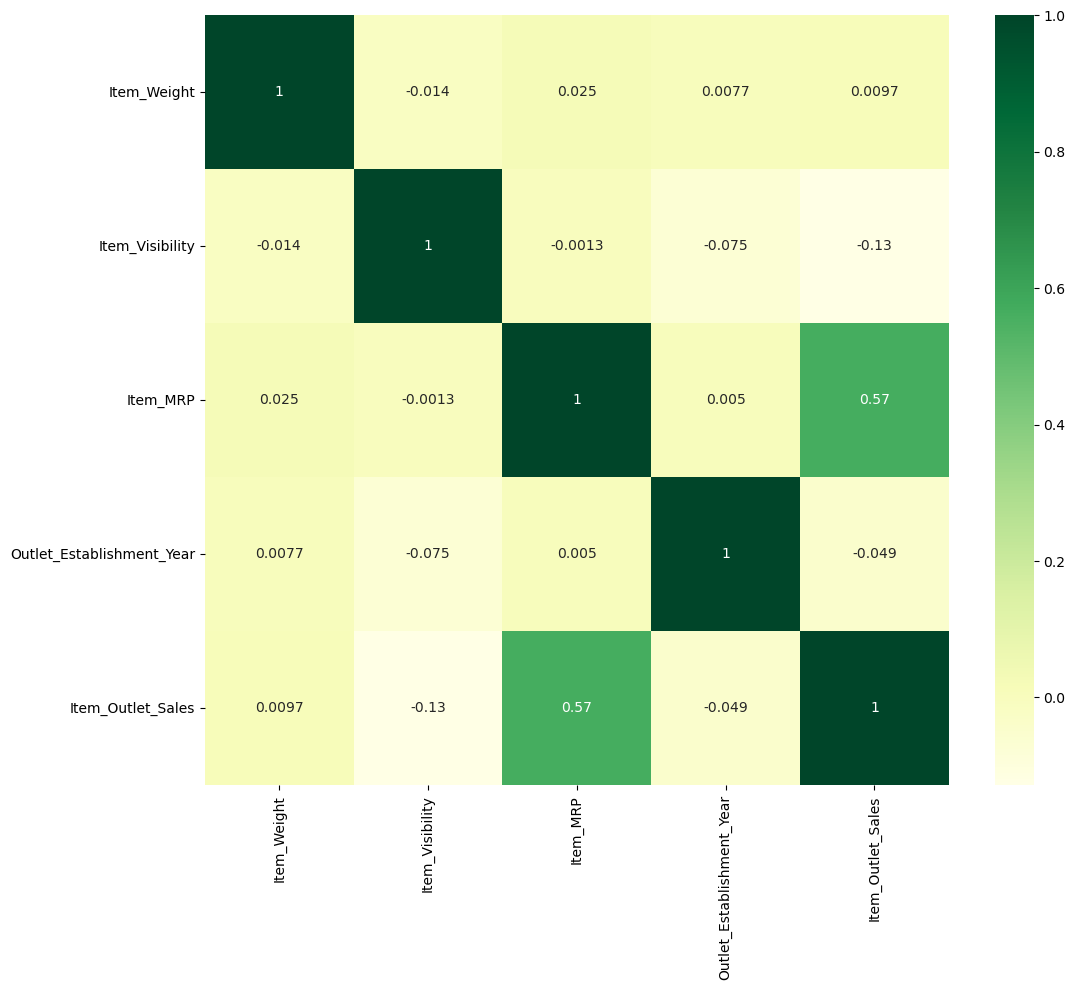

In [22]:
# Define MatplotLib fig and ax objects using plt.subplots()
fig, ax = plt.subplots(figsize = (12,10))
corr = df.corr()

#Define a MatplotLib ax object using sns.heatmap()
ax = sns.heatmap(corr, cmap= 'YlGn', annot = True);

- There is a moderate positive correlation between Item_MRP and Item_Outlet_Sales. 

## **Explanatory Data Analysis**

## **Possible Questions to Answer:**
1. What are the average product sales for each product category?
2. What were the sales like for Supermarket stores? 

In [23]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,missing,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**1. What are the average product sales for each product category?**

In [24]:
means = df.groupby('Item_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False)
means

Item_Type
Starchy Foods            2374.332773
Seafood                  2326.065928
Fruits and Vegetables    2289.009592
Snack Foods              2277.321739
Household                2258.784300
Dairy                    2232.542597
Canned                   2225.194904
Breads                   2204.132226
Meat                     2158.977911
Hard Drinks              2139.221622
Frozen Foods             2132.867744
Breakfast                2111.808651
Health and Hygiene       2010.000265
Soft Drinks              2006.511735
Baking Goods             1952.971207
Others                   1926.139702
Name: Item_Outlet_Sales, dtype: float64

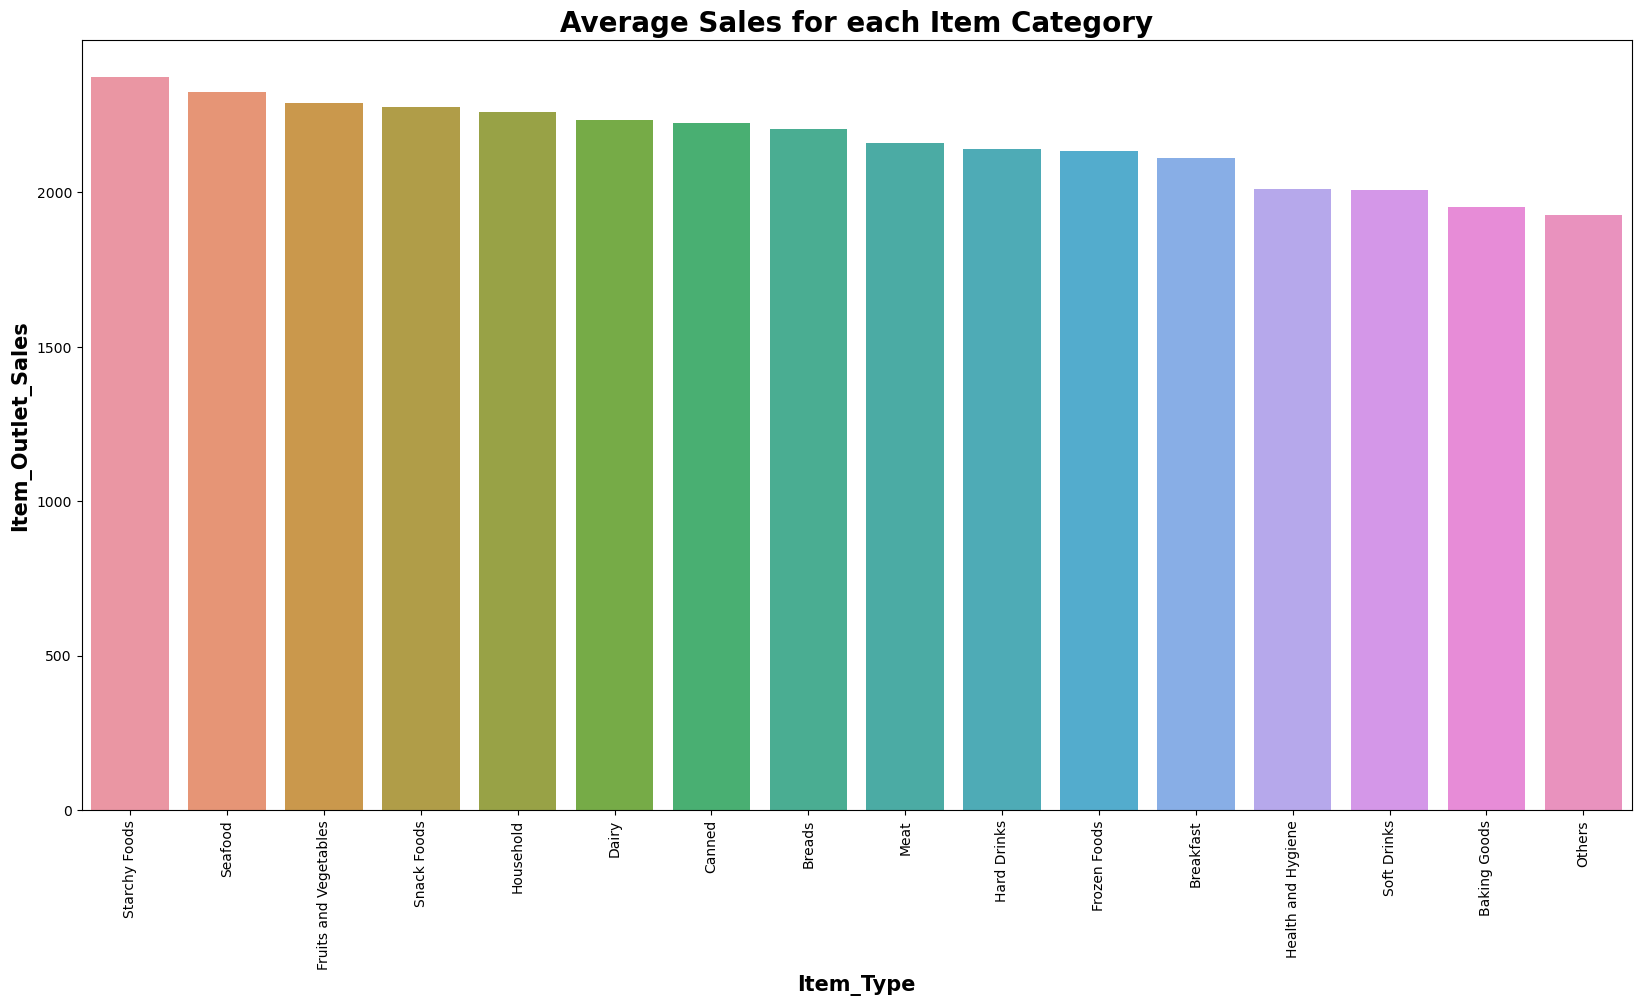

In [25]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.barplot(data=df,x='Item_Type', y = 'Item_Outlet_Sales', order = means.index, ci = None)
plt.xticks(rotation = 90)
ax.set_title('Average Sales for each Item Category', fontsize = 20, fontweight = 'bold');
ax.set_xlabel('Item_Type', fontsize = 15, fontweight = 'bold')
ax.set_ylabel('Item_Outlet_Sales', fontsize = 15, fontweight = 'bold');

The top five highest average sales are as follows:
- Starchy Foods: $2,374.33

- Seafood: $2,326.07

- Fruits and Vegetables: $2,289.01

- Snack Foods: $2,277.32

- Household: $2,258.78

The bottom five average sales are as follows:
- Breakfast: $2,111.81

- Health and Hygiene: $2,010.00

- Soft Drinks: $2,006.51

- Baking Goods: $1,952.97

- Others: $1,926.14

**2. What were the sales like for Supermarket stores?**

In [26]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [27]:
outlet_type = df[df['Outlet_Type'] == 'Supermarket Type1']
outlet_type = outlet_type['Item_Type'].value_counts().sort_values(ascending = False).to_frame()
outlet_type.head()

,Item_Type
Fruits and Vegetables,805
Snack Foods,785
Household,597
Frozen Foods,572
Dairy,450


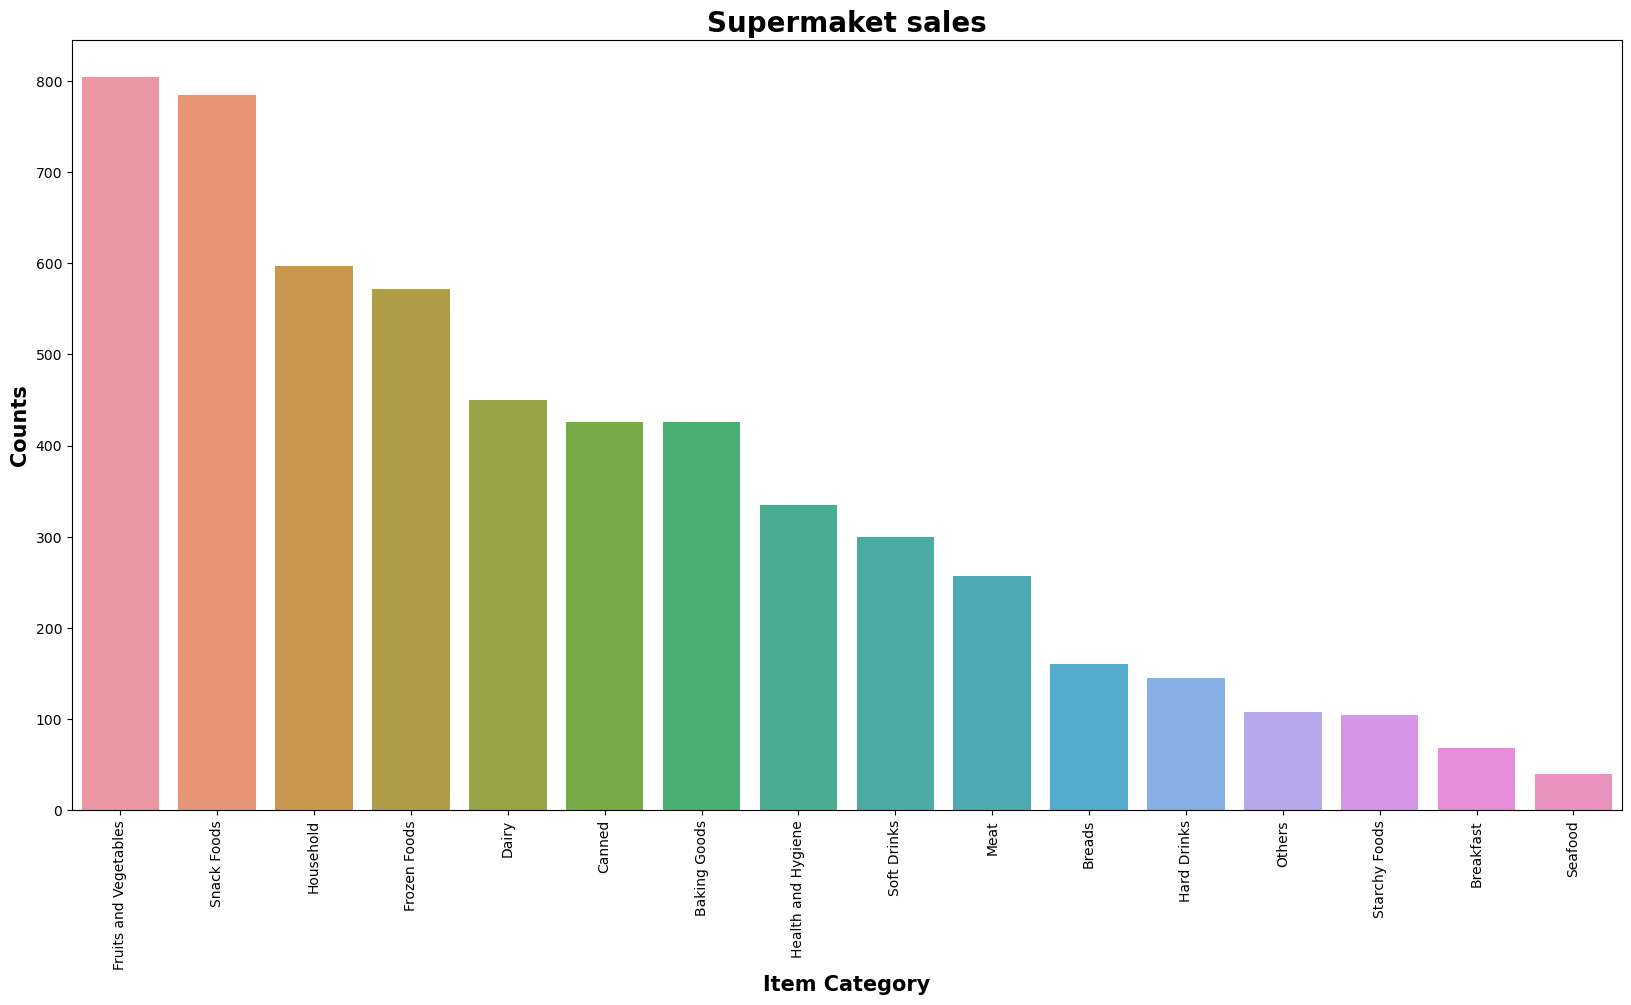

In [28]:
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.barplot(data=outlet_type,x = outlet_type.index, y = outlet_type['Item_Type'])
plt.xticks(rotation = 90)
ax.set_title('Supermaket sales', fontsize = 20, fontweight = 'bold');
ax.set_xlabel('Item Category', fontsize = 15, fontweight = 'bold')
ax.set_ylabel('Counts', fontsize = 15, fontweight = 'bold');

This graph shows that Supermarkets have the highest sales in fruit and vegetables and the lowest sales in Seafood. 

# **Preprocesing for Machine Learning**

## **Task:**

Will make predictions about future sales based on the data provided.

## **Reload the Data**

In [29]:
from sklearn import set_config
set_config(display='diagram')

In [30]:
#Load the data
original_df= pd.read_csv("Data/sales_predictions_2023.csv")
df = original_df.copy()
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [31]:
# Make a copy of original to avoid manipulation
original = df.copy()

## **Check for Duplicated, Missing, or Erroneous Data**

In [32]:
# Check to see if there are any duplicate rows
original.duplicated().sum()

0

No duplicates found.

In [33]:
# checking inconsistencies in object datatypes
object_type = original.dtypes[original.dtypes == 'object']
for i in object_type.index:
  print(i, '---')
  print(df[i].unique())
  print("")

Item_Identifier ---
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']

Item_Fat_Content ---
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

Item_Type ---
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

Outlet_Identifier ---
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

Outlet_Size ---
['Medium' nan 'High' 'Small']

Outlet_Location_Type ---
['Tier 1' 'Tier 3' 'Tier 2']

Outlet_Type ---
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']



In [34]:
#Fixing inconsistencies
original['Item_Fat_Content'] = original['Item_Fat_Content'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})

In [35]:
original['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

## **Handle Missing Values**

In [36]:
# Display the sum of missing values
original.isna().sum().sum()

3873

In [37]:
# Display the sum of missing values
original.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [38]:
# Display the percentage of missing values by column
print(original.isna().sum()/len(original)*100)

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64


- Will use median for 'Item_Weight' to account for any outliers
- Will use most_frequent for 'Outlet_Size' since it's nominal

## **Split the Data (Validation Split)**

- Target: 'Item_Outlet_Sales'
- Features: the rest of the relevant variables

In [39]:
# Split X and y, you are predicting price
X = original.drop(columns=['Item_Outlet_Sales']).copy()
y = original['Item_Outlet_Sales'].copy()

# split training and test
# set random_state to 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [40]:
# Display the first 5 values of the dataset
X_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,NCG06,16.350,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,FDV57,15.250,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,FDM27,12.350,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,FDG24,7.975,Low Fat,0.014628,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,FDD05,19.350,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,2002,NaN,Tier 2,Supermarket Type1


In [41]:
# Display the first (5) values of the dataset
y_train.head()

4776     515.3292
7510    3056.0220
5828    1577.9460
5327    1331.6000
4810    1687.1372
Name: Item_Outlet_Sales, dtype: float64

## **Preprocessing Object**

In [42]:
# Instantiate the transformers
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [43]:
df['Outlet_Size'].dtype

dtype('O')

## **Instantiate Transformers**

In [44]:
#Transformers
freq_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')
#Scaler
scaler = StandardScaler()
#OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

## **Instantiate Pipeline**

In [45]:
num_pipeline = make_pipeline(median_imputer, scaler)
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [46]:
cat_pipeline = make_pipeline(freq_imputer, ohe)
cat_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

## **Instantiate ColumnTransformer**

In [47]:
num_tuple = (num_pipeline, num_selector)
cat_tuple = (cat_pipeline, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002CF8FDDDA00>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002CF8FDDD5B0>)])

## **Transform Data**

In [48]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002CF8FDDDA00>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002CF8FDDD5B0>)])

In [49]:
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## **View Result**

In [50]:
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 1592)




array([[ 0.82748547, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.56664432, -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.12102782,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.12389588, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.77599877, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82748547, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

In [51]:
X_test_processed.shape

(2131, 1592)

In [52]:
print(X_train_processed)
print(X_train_processed.shape)

[[ 0.82748547 -0.71277507  1.82810922 ...  0.          1.
   0.        ]
 [ 0.56664432 -1.29105225  0.60336888 ...  0.          1.
   0.        ]
 [-0.12102782  1.81331864  0.24454056 ...  1.          0.
   0.        ]
 ...
 [ 1.12389588 -0.92052713  1.52302674 ...  1.          0.
   0.        ]
 [ 1.77599877 -0.2277552  -0.38377708 ...  1.          0.
   0.        ]
 [ 0.82748547 -0.95867683 -0.73836105 ...  1.          0.
   0.        ]]
(6392, 1592)


In [53]:
print(X_test_processed)
print(X_test_processed.shape)

[[ 0.34137241 -0.77664625 -0.99881554 ...  1.          0.
   0.        ]
 [-1.16913501  0.1003166  -1.58519423 ...  1.          0.
   0.        ]
 [ 0.38879808 -0.48299432 -1.59578435 ...  1.          0.
   0.        ]
 ...
 [-1.12882319  1.21832428  1.09397975 ...  1.          0.
   0.        ]
 [-1.48688696 -0.77809567 -0.36679966 ...  1.          0.
   0.        ]
 [ 0.53107507 -0.77976293  0.11221189 ...  1.          0.
   0.        ]]
(2131, 1592)


# **Machine Learning Using a Regression Model**

## **Task**

- Help the retailer understand the properties of products and outlets that play a crucial role in predicting sales. 

# **Import Libraries**

In [54]:
# Pandas
import pandas as pd
# Numpy
import numpy as np
# MatPlotLib
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Regression Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# Set global scikit-learn configuration 
from sklearn import set_config
# Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

from IPython.core.display import clear_output

## Filter ALL warnings
import warnings
warnings.filterwarnings('ignore')

# **Functions**

In [55]:
# Create a function to take the true and predicted values
# and print MAE, MSE, RMSE, and R2 metrics
def model_metrics(pipe, X_train, y_train, X_test, y_test, 
                       model_name='Regression Model'):
  
  """Takes a regression model, training features and target and testing features and target.
  Returns a dataframe of regression metrics"""

  # Predictions
  train_pred = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)
  
  metrics = ['train_MAE','test_MAE', 
             'train_RMSE', 'test_RMSE', 
             'train_R2', 'test_R2']
  
  # Train
  train_mae = round(mean_absolute_error(y_train, train_pred),4)
  train_rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
  train_r2 = round(r2_score(y_train, train_pred),4)

  # Test
  test_mae = round(mean_absolute_error(y_test, test_preds),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
  test_r2 = round(r2_score(y_test, test_preds),4)

  # Output Dataframe
  scores = pd.DataFrame(columns=metrics, index=[f'{model_name}'])
  scores.loc[f'{model_name}', :] = [train_mae, test_mae,
                                          train_rmse, test_rmse,
                                          train_r2, test_r2]

  return scores

# **Load and Inspect the Data**

## **Load the Data**

In [56]:
# Load Data
path = "Data/sales_predictions_2023.csv"
df = pd.read_csv(path)

In [57]:
# Display the first (5) rows of the dataframe
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


- The data appears to have loaded correctly.

In [58]:
## Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 8523 rows, and 12 columns.
The rows represent 8523 observations, and the columns represent 11 features and 1 target variable.


In [59]:
## Display the column names and datatypes for each column
## Columns with mixed datatypes are identified as an object datatype
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [60]:
## Display the column names, count of non-null values, and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [61]:
## Display the descriptive statistics for the numeric columns
df.describe(include="number")

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [62]:
## Display the descriptive statistics for the numeric columns
df.describe(include="object")

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


#**Clean the Data**

##**Remove Unnecessary Columns**

- Dropping "Item_Identifier" column due to high cardinality, (1559 is a high number of unique labels or classes). High cardinality will create a very sparse dataset when it is One Hot Encoded, which can negatively impact the models' medtics, and greatly increase processing times. 

In [63]:
# Drop a single column
df.drop(columns = 'Item_Identifier', inplace = True)

In [64]:
# Display the first (5) rows of the dataframe
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


- Confirmed, the column has been dropped.

## **Remove Unnecessary Rows**

### **Duplicates**

In [65]:
# Display the number of duplicate rows in the dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


## **Inspect Column Datatypes for Errors**

In [66]:
# Display column names and datatypes
df.dtypes

Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

## **Inspect Column Names for Errors**

- Check for common syntax errors which may include extra white spaces at the beginning or end of strings or column names.
- Check for typos or inconsistencies in strings that need to be fixed.

In [67]:
# Display column names
df.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

- No errors noted.

**Object Inconsistencies**

In [68]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [69]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [70]:
df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].astype('object')

## **Inspect Values for Errors**

## **Missing Values**

In [71]:
# Display the total number of missing values
print(f'There are {df.isna().sum().sum()} missing values.')

There are 3873 missing values.


In [72]:
# Display the count of missing values by column
print(df.isna().sum())

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [73]:
# Display the percentage of missing vlaues by column
print(df.isna().sum()/len(df)*100)

Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64


- **The missing values will need to be imputed:**
  - We will need to use the median for "Item_Weight" to account for outliers
  - We will need to use most_frequent for "Outlet_Type".

###**Number Columns**

- Check for unusual or impossible values. (Example a weight, or height that is negative in value.)

In [74]:
# Display the descriptive statistics for all columns
df.describe(include="number")

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,2181.288914
std,4.643456,0.051598,62.275067,1706.499616
min,4.555000,0.000000,31.290000,33.290000
25%,8.773750,0.026989,93.826500,834.247400
50%,12.600000,0.053931,143.012800,1794.331000
75%,16.850000,0.094585,185.643700,3101.296400
max,21.350000,0.328391,266.888400,13086.964800


In [75]:
# Display the descriptive statistics for all columns
df.describe(include='object')

,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,2,16,10,9,3,3,4
top,Low Fat,Fruits and Vegetables,OUT027,1985,Medium,Tier 3,Supermarket Type1
freq,5517,1232,935,1463,2793,3350,5577


# **Split the Data**

In [76]:
# Define features (X) and target (y)
target = 'Item_Outlet_Sales'
X = df.drop(columns = [target]).copy()
y = df[target].copy()

In [77]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# **Prepare the Data**

## **Column Selector**

In [78]:
#Instantiate the column selectors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

## **Transformers**

In [79]:
#Instantiate the transformers
#Imputers
median_imputer = SimpleImputer(strategy='median')
freq_imputer = SimpleImputer(strategy='most_frequent')
#Scaler
scaler = StandardScaler()
#OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')

## **Pipeline**

In [80]:
#Pipeline
num_pipeline = make_pipeline(median_imputer, scaler)
cat_pipeline = make_pipeline(freq_imputer, ohe)


## **Tuples**

In [81]:
# Create tuples
number_tuple = (num_pipeline, num_selector)
cat_tuple = (cat_pipeline, cat_selector)

## **Column Transformer**

In [82]:
# Create the preprocessor using make_column_transformer
preprocessor = make_column_transformer(number_tuple, cat_tuple,
                                       remainder='drop')

## **Check that the preprocessing is working**

In [83]:
#fit on train
preprocessor.fit(X_train)

#transform train and test
X_train_processed = pd.DataFrame(preprocessor.transform(X_train),
                                 columns=preprocessor.get_feature_names_out())
X_test_processed = pd.DataFrame(preprocessor.transform(X_test),
                                columns=preprocessor.get_feature_names_out())
#Check for missing values and that data is scaled and one-hot encoded
display(X_train_processed.head(2))
X_train_processed.info()

ValueError: Shape of passed values is (6392, 1), indices imply (6392, 50)

# **Model the Data**

## **Functions**

In [ ]:
## Display model performance metrics using a function
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics for a model
def eval_regression(y_true, y_pred, name='model'):
  """Takes true targets and predictions from a regression model and prints
  MAE, MSE, RMSE, AND R2 scores
  Set 'name' to name of model and 'train' or 'test' as appropriate"""
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  print(f'{name} Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

## **Baseline Model**

- Instantiate the baseline model using the 'mean' startegy.
- Create a model pipeline using the preprocessor and model.
- Fit the model pipeline with the X_train dataset.

In [ ]:
# Create an instance of the model
dummy = DummyRegressor(strategy='mean')

# Create a model pipeline
dummy_pipe = make_pipeline(preprocessor, dummy)

# Fit the model
dummy_pipe.fit(X_train_processed, y_train)

## **Metrics**

In [ ]:
## Display model performance metrics using a function
train_preds = dummy_pipe.predict(X_train_processed)
test_preds = dummy_pipe.predict(X_test_processed)

eval_regression(y_train, train_preds, name='Baseline Regression Train')
eval_regression(y_test, test_preds, name='Baseline Regression Test')

# **Linear Regression Model**

- Instantiate the model.
- Create a model pipeline using the preprocessor and model.
- Fit the model pipeline on the X_train dataset.

In [ ]:
# Create an instance of the model
lin_reg = LinearRegression()

# Create a model pipeline
lin_reg_pipe = make_pipeline(preprocessor, lin_reg)

#Fit the model
lin_reg_pipe.fit(X_train_processed, y_train)

### **Metrics**

In [ ]:
## Display model performance metrics using a function

train_preds = lin_reg_pipe.predict(X_train_processed)
test_preds = lin_reg_pipe.predict(X_test_processed)

lin_train_eval = eval_regression(y_train, train_preds, name='Linear Regression Train')
lin_test_eval = eval_regression(y_test, test_preds, name='Linear Regression Test')

# **Decision Tree Model**

## **Baseline Model**

## **Decision Tree Metrics**

In [ ]:
#Make an instance of the Model
dec_tree = DecisionTreeRegressor(random_state = 42)

In [ ]:
#Fit the model using the training data
dec_tree.fit(X_train_processed, y_train)

In [ ]:
# Predict the target values for the training set and the test set
train_preds = dec_tree.predict(X_train_processed)
test_preds = dec_tree.predict(X_test_processed)

## **Evaluate the Model**

In [ ]:
#Evaluate the model
train_score = dec_tree.score(X_train_processed, y_train)
test_score = dec_tree.score(X_test_processed, y_test)
print(train_score)
print(test_score)

## **Tune the Model**

In [ ]:
#What was the depth of our default tree?
dec_tree.get_depth()

In [ ]:
depths = range(2,45)
scores = pd.DataFrame(index=depths, columns=['Train', 'Test'])

for depth in depths:
  dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
  dec_tree.fit(X_train_processed, y_train)
  scores.loc[depth, 'Train'] = dec_tree.score(X_train_processed, y_train)
  scores.loc[depth, 'Test'] = dec_tree.score(X_test_processed, y_test)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(depths, scores['Test'])
plt.xlabel('Depth')
plt.ylabel('R2 Score');

In [ ]:
scores.sort_values(by='Test', ascending=False).head()

In [ ]:
## sort the dataframe by test scores and save the index (k) of the best score
best_depth = sorted_scores.index[0]
best_depth

**Best decision tree**
 - max_depth=5


In [ ]:
# instantiate best DecisionTreeRegressor
best_dec_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
# fit
best_dec_tree.fit(X_train_processed, y_train)
# r2 scores
best_tree_train_score = best_dec_tree.score(X_train_processed, y_train)
best_tree_test_score = best_dec_tree.score(X_test_processed, y_test)

print(f'Best Training Decision Tree Score: {best_tree_train_score}')
print(f'Best Testing Decision Tree Score: {best_tree_test_score}')

## **Metrics**

In [ ]:
dec_train_predict = best_dec_tree.predict(X_train_processed)
dec_test_predict = best_dec_tree.predict(X_test_processed)

In [ ]:
dec_train_eval = eval_regression(y_train, dec_train_predict, name='Decision Tree Train')
print(dec_train_eval)

dec_test_eval = eval_regression(y_test, dec_test_predict, name='Decision Tree Test')
print(dec_test_eval)

# **Recommendation:**

Which model would you recommend to a stakeholder? Why?

- The Tuned Decision Tree model had the lowest RMSE, which is likely to be the most important metric for this problem. However MAE is easier to understand, and it also had the lowest MAE, so that might be good for reporting.

# Revisited: Importances and Coefficients

## Load Libraries

In [ ]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance

## saving variables
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

## **Load Data**

In [ ]:
df = pd.read_csv("Data/sales_predictions_2023.csv")
df.info()
df.head(3)

## Clean Data

In [ ]:
# check for object inconsistencies
object_type = df.dtypes[df.dtypes == 'object']
for i in object_type.index:
  print(i, '---')
  print(df[i].unique())
  print("")

In [ ]:
# fix inconsistencies
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})
df['Item_Fat_Content'].unique()

## Define X and y

In [ ]:
## Define X and y
target = 'Item_Outlet_Sales'
X = df.drop(columns=target).copy()
y = df[target].copy()
X

In [ ]:
## Drop unwanted/inappropriate columns 
bad_cols = ['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year']
X = X.drop(columns=bad_cols)
## Perform a train-test-split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

## Making a Preprocessing Pipeline

In [ ]:
## Create categorical pipeline
cat_selector = make_column_selector(dtype_include='object')
cat_selector(X_train)

In [ ]:
## Create numeric pipelien
num_selector = make_column_selector(dtype_include='number')
num_selector(X_train)

In [ ]:
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse_output=False,
                                      drop='if_binary'))

num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [ ]:
preprocessor = make_column_transformer((cat_pipe, cat_selector),
                                       (num_pipe, num_selector),)
preprocessor

## **Get Features Names + Verbose Feature Names Out**

In [ ]:
## make the preprocessing column transformer WITH CORRECT ARGS!
preprocessor = make_column_transformer((num_pipe, num_selector),
                                       (cat_pipe,cat_selector),
                                      verbose_feature_names_out=False)
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

In [ ]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
feature_names

## **Scaled version to see how coefficients are different**

In [ ]:
scaling_preprocessor = make_pipeline(preprocessor, StandardScaler())
scaling_preprocessor.fit(X_train)
X_train_scaled_df = pd.DataFrame(scaling_preprocessor.transform(X_train),
                          columns=scaling_preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_scaled_df = pd.DataFrame(scaling_preprocessor.transform(X_test),
                          columns=scaling_preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_scaled_df)

# **Modeling**

## **Model 1 - Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error

In [ ]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

In [ ]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

## **Extract Coefficients**

In [ ]:
# access the .coef_ 
coefs = lin_reg.coef_
coefs

In [ ]:
# Intercept
intercept = lin_reg.intercept_
intercept

In [ ]:
## Saving the coefficients
coefs = pd.Series(coefs, index=lin_reg.feature_names_in_)
coefs.sort_values(ascending=False)

In [ ]:
coeffs = get_coeffs_linreg(lin_reg)
coeffs

In [ ]:
## formatting numbers to not use , thousands sep, and 4 digits floats
pd.set_option('display.float_format', lambda x: f"{x:,.4f}")

In [ ]:
# Define get_coefficients function to extract LinReg coefficients
def get_coefficients(lin_reg):
    coefs = lin_reg.coef_
    coefs = pd.Series(coefs, index=lin_reg.feature_names_in_)
    return coefs

# Scaled vs Unscaled Data

- Scaled: absolute value of coefficients show importance of features, or change in target due to change in one standard deviation of feature

- Unscaled: show impact of change of one unit for each feature on target.

## Shows what coeficients look like for Scaled data

In [ ]:
# Fit a new model on a scaled version of the data
lin_reg_scaled = LinearRegression().fit(X_train_scaled_df, y_train)

# Examine new coefficients
get_coefficients(lin_reg_scaled).sort_values(ascending=False)

## **Interpreting Coefficients**

- The top 3 most impactful features are: 
    - Outlet_Type_Supermarket Type3 
        - increasing this feature by 1 unit will cause a 991.9675 change in the target
    - Item_MRP
        - increasing this feature by 1 unit will cause a 984.2280 change in the target
    - Outlet_Type_Supermarket Type1
        - increasing this feature by 1 unit will cause a 892.9834 change in the target

## **Visualizing Coefficients**

In [ ]:
ax = coefs.sort_values().plot(kind='barh', figsize=(8,35))
ax.axvline(0, color='k')
ax.set(xlabel='Item_Outlet_Sales', title="Coefficients - All");

## **Functionizing Coefficient Visualization**

In [ ]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [ ]:
ax = plot_coeffs(coeffs,top_n=15)
for bar in ax.patches:
    ## calculate center of bar
    bar_ax = bar.get_y() + bar.get_height() / 2
    ## get the value to annotate
    val = bar.get_width()
    
    if val < 0:
        val_pos = 0
    else:
        val_pos = val
    
    # ha and va stand for the horizontal and vertical alignment
    ax.annotate(f"{val:.3f}", (val_pos,bar_ax),
                ha='left', va='center',size=10,
                xytext=(4,0), textcoords='offset points')

In [ ]:
# Random Forest Model